### 1.  Installing Dependencies

In [1]:
!pip install transformers

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### 2. Importing the Libraries

In [4]:
import pandas as pd
import torch 
import numpy as np
from transformers import AutoTokenizer, BertForTokenClassification, Trainer,TrainingArguments
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import SGD
import datasets
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix,ConfusionMatrixDisplay, precision_score, recall_score
import matplotlib.pyplot as plt

### 3. Reading & Preprocessing the dataset

In [5]:
def read_datasets(path):
    f = open(path)
    words= []
    tags= []
    word= []
    tag= []
    mx = []
    for line in f.readlines():
        line= line.split('\t')
        if len(line)==2:
            word.append(line[0])
            tag.append(line[1].strip())
        else:
            mx.append(len(word))
#             word = ' '.join(word)
#             tag = ' '.join(tag)
            words.append(word)
            tags.append(tag)
            if len(word)!=len(tag):
                print(line)
            word =[]
            tag = []
    print(len(words),len(tags))
    df = pd.DataFrame(columns=["text","labels"])
#     words = words '.join(words)
    df["text"] = words
    df["labels"] = tags
#     ' '.join(tags)
    return words, tags, df

train_words, train_tags, train_df = read_datasets('/kaggle/input/nlp-project-dataset-final/dataset/final_train.txt')
val_words, val_tags, val_df = read_datasets('/kaggle/input/nlp-project-dataset-final/dataset/final_val.txt')
test_words, test_tags, test_df = read_datasets('/kaggle/input/nlp-project-dataset-final/dataset/final_test.txt')

350 350
50 50
100 100


In [6]:
unique_tags = ['O','B-Task', 'I-Task', 'B-Process', 'I-Process', 'B-Material', 'I-Material']
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}
print("Unique Tags : ", unique_tags)
print("Tags to ID  : ", tag2id)
print("ID to Tags : ", id2tag)

Unique Tags :  ['O', 'B-Task', 'I-Task', 'B-Process', 'I-Process', 'B-Material', 'I-Material']
Tags to ID  :  {'O': 0, 'B-Task': 1, 'I-Task': 2, 'B-Process': 3, 'I-Process': 4, 'B-Material': 5, 'I-Material': 6}
ID to Tags :  {0: 'O', 1: 'B-Task', 2: 'I-Task', 3: 'B-Process', 4: 'I-Process', 5: 'B-Material', 6: 'I-Material'}


In [7]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
tokenizer

BertTokenizerFast(name_or_path='allenai/scibert_scivocab_uncased', vocab_size=31090, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [8]:
train_encodings = tokenizer(train_words, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True, max_length=512)
val_encodings = tokenizer(val_words, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True,max_length=512)
test_encodings = tokenizer(test_words, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True,max_length=512)

In [9]:
def encode_tags(tags, encodings):
    labels = [[tag2id[tag] for tag in doc] for doc in tags]
    encoded_labels = []
    for doc_labels, doc_offset in zip(labels, encodings.offset_mapping):
        doc_enc_labels = np.ones(len(doc_offset),dtype=int) * 0
        arr_offset = np.array(doc_offset)

        doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels
        encoded_labels.append(doc_enc_labels.tolist())

    return encoded_labels

train_labels = encode_tags(train_tags, train_encodings)
val_labels = encode_tags(val_tags, val_encodings)
test_labels = encode_tags(test_tags, test_encodings)

In [10]:
len(train_encodings.input_ids[4])

341

In [11]:
l = [0]*7
for i in range(len(train_labels)):
    for j in range(len(train_labels[i])):
        l[train_labels[i][j]] +=1
l

[114876, 323, 1235, 644, 1298, 465, 509]

In [12]:
class SemEvalDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings.pop("offset_mapping")
val_encodings.pop("offset_mapping")
test_encodings.pop("offset_mapping")
train_dataset = SemEvalDataset(train_encodings, train_labels)
val_dataset = SemEvalDataset(val_encodings, val_labels)
test_dataset = SemEvalDataset(test_encodings, test_labels)

### 4. Finetuning the model

In [13]:
from transformers import AutoModelForTokenClassification, Trainer, TrainingArguments

BATCH_SIZE = 4
EPOCHS = 10
# metric_name = "f1"
training_args = TrainingArguments(
    output_dir = "./final_submisssion",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 2e-5,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size = BATCH_SIZE,
    num_train_epochs = EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    push_to_hub=True,
    do_train = True,
    do_eval = True,
    do_predict = True,
   remove_unused_columns = False
)

In [14]:
model = AutoModelForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=len(unique_tags))


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)
trainer.train()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Download file pytorch_model.bin:   0%|          | 8.00k/417M [00:00<?, ?B/s]

Download file runs/May03_08-24-10_c9130a6bee88/events.out.tfevents.1683102261.c9130a6bee88.23.3: 100%|########…

Download file runs/May03_05-24-06_3dcdbfb22bcd/events.out.tfevents.1683091469.3dcdbfb22bcd.23.0: 100%|########…

Download file runs/May03_08-03-31_c9130a6bee88/1683101231.9381242/events.out.tfevents.1683101231.c9130a6bee88.…

Download file runs/May03_08-03-31_c9130a6bee88/events.out.tfevents.1683101231.c9130a6bee88.23.0: 100%|########…

Download file runs/May03_05-24-06_3dcdbfb22bcd/1683091469.316857/events.out.tfevents.1683091469.3dcdbfb22bcd.2…

Clean file runs/May03_08-24-10_c9130a6bee88/events.out.tfevents.1683102261.c9130a6bee88.23.3:  15%|#4        |…

Clean file runs/May03_05-24-06_3dcdbfb22bcd/events.out.tfevents.1683091469.3dcdbfb22bcd.23.0:  16%|#5        |…

Download file runs/May03_08-24-10_c9130a6bee88/1683102261.6369088/events.out.tfevents.1683102261.c9130a6bee88.…

Download file training_args.bin: 100%|##########| 3.50k/3.50k [00:00<?, ?B/s]

Clean file runs/May03_08-03-31_c9130a6bee88/1683101231.9381242/events.out.tfevents.1683101231.c9130a6bee88.23.…

Clean file runs/May03_08-03-31_c9130a6bee88/events.out.tfevents.1683101231.c9130a6bee88.23.0:  14%|#4        |…

Clean file runs/May03_05-24-06_3dcdbfb22bcd/1683091469.316857/events.out.tfevents.1683091469.3dcdbfb22bcd.23.1…

Clean file runs/May03_08-24-10_c9130a6bee88/1683102261.6369088/events.out.tfevents.1683102261.c9130a6bee88.23.…

Download file runs/May03_08-03-31_c9130a6bee88/events.out.tfevents.1683101667.c9130a6bee88.23.2: 100%|########…

Clean file training_args.bin:  29%|##8       | 1.00k/3.50k [00:00<?, ?B/s]

Clean file runs/May03_08-03-31_c9130a6bee88/events.out.tfevents.1683101667.c9130a6bee88.23.2: 100%|##########|…

Clean file pytorch_model.bin:   0%|          | 1.00k/417M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,No log,0.129429
2,No log,0.113452
3,No log,0.103488
4,No log,0.108510
5,No log,0.117000
6,No log,0.126572
7,No log,0.132575
8,No log,0.138141
9,No log,0.140645
10,No log,0.142910


/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqu

TrainOutput(global_step=440, training_loss=0.0919895432212136, metrics={'train_runtime': 1060.1061, 'train_samples_per_second': 3.302, 'train_steps_per_second': 0.415, 'total_flos': 609124563663000.0, 'train_loss': 0.0919895432212136, 'epoch': 10.0})

### 5. Model Evaluation

In [61]:
trainer.evaluate()

/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.10348787158727646,
 'eval_runtime': 0.9846,
 'eval_samples_per_second': 50.783,
 'eval_steps_per_second': 7.11,
 'epoch': 10.0}

In [62]:
predictions, labels, metrics = trainer.predict(test_dataset, metric_key_prefix="predict")

In [63]:
predictions.shape

(100, 339, 7)

In [64]:
y_pred = np.argmax(predictions, 2)
y_pred.shape

(100, 339)

In [65]:
y_pred_fl = y_pred.flatten()
y_true = labels.flatten()

Confusion Matrix : 


Text(0.5, 0.98, 'Plot of confusion matrix')

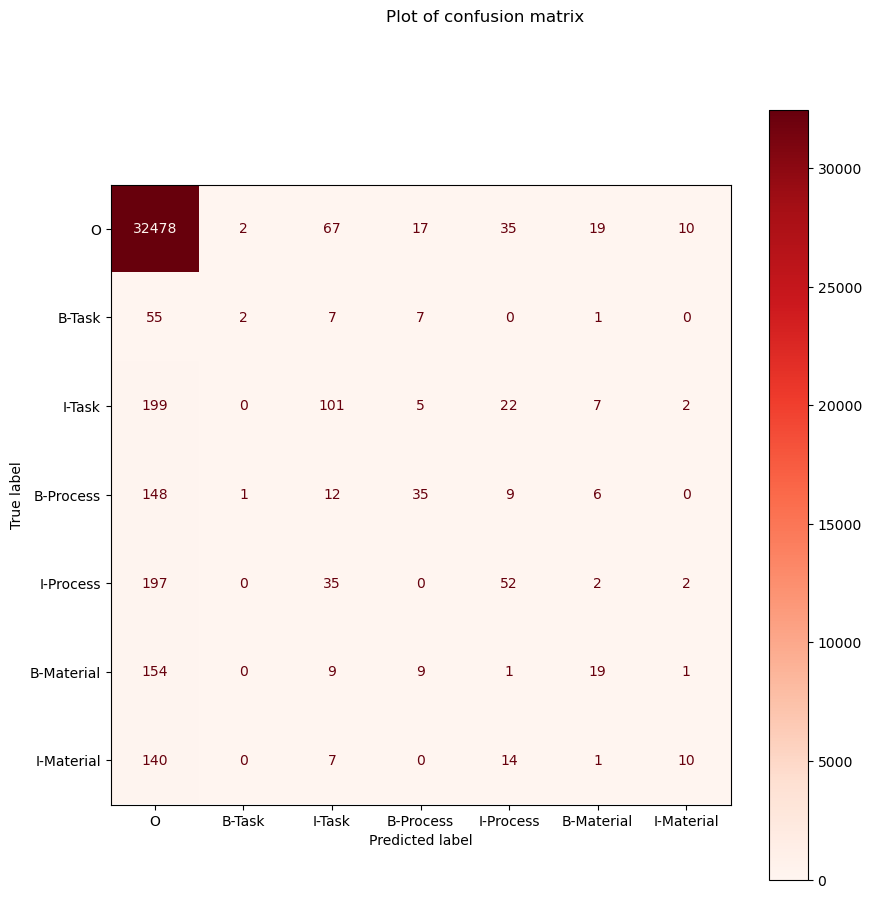

In [66]:
print("Confusion Matrix : ")
cm = confusion_matrix(y_pred_fl, y_true)
display = ConfusionMatrixDisplay.from_predictions(y_true,y_pred_fl,display_labels = unique_tags,cmap=plt.cm.Reds)
fig = display.figure_
fig.set_figwidth(10)
fig.set_figheight(10) 
fig.suptitle('Plot of confusion matrix')

In [67]:
cr = classification_report(y_true, y_pred_fl,target_names=unique_tags)
print(cr)

              precision    recall  f1-score   support

           O       0.97      1.00      0.98     32628
      B-Task       0.40      0.03      0.05        72
      I-Task       0.42      0.30      0.35       336
   B-Process       0.48      0.17      0.25       211
   I-Process       0.39      0.18      0.25       288
  B-Material       0.35      0.10      0.15       193
  I-Material       0.40      0.06      0.10       172

    accuracy                           0.96     33900
   macro avg       0.49      0.26      0.31     33900
weighted avg       0.95      0.96      0.96     33900



In [69]:
print("Precision Score - ")
class_wise = precision_score(y_true, y_pred_fl, average=None)
print("1. Class-wise :")
for i in range(len(class_wise)):
    print("\t", unique_tags[i], "\t", round(class_wise[i],4))
print()
print("2. micro : ", precision_score(y_true, y_pred_fl, average='micro'))
print("3. macro : ", precision_score(y_true, y_pred_fl, average='macro'))

Precision Score - 
1. Class-wise :
	 O 	 0.9732
	 B-Task 	 0.4
	 I-Task 	 0.4244
	 B-Process 	 0.4795
	 I-Process 	 0.391
	 B-Material 	 0.3455
	 I-Material 	 0.4

2. micro :  0.9645132743362832
3. macro :  0.48764200432681554


In [70]:
print("Recall Score - ")
class_wise = recall_score(y_true, y_pred_fl, average=None)
print("1. Class-wise :")
for i in range(len(class_wise)):
    print("\t", unique_tags[i], "\t", round(class_wise[i],4))
print()
print("2. micro : ", recall_score(y_true, y_pred_fl, average='micro'))
print("3. macro : ", recall_score(y_true, y_pred_fl, average='macro'))

Recall Score - 
1. Class-wise :
	 O 	 0.9954
	 B-Task 	 0.0278
	 I-Task 	 0.3006
	 B-Process 	 0.1659
	 I-Process 	 0.1806
	 B-Material 	 0.0984
	 I-Material 	 0.0581

2. micro :  0.9645132743362832
3. macro :  0.26097045728674556


In [71]:
print("F1 Score - ")
class_wise = f1_score(y_true, y_pred_fl, average=None)
print("1. Class-wise :")
for i in range(len(class_wise)):
    print("\t", unique_tags[i], "\t", round(class_wise[i],4))
print()
print("2. micro : ", f1_score(y_true, y_pred_fl, average='micro'))
print("3. macro : ", f1_score(y_true, y_pred_fl, average='macro'))

F1 Score - 
1. Class-wise :
	 O 	 0.9842
	 B-Task 	 0.0519
	 I-Task 	 0.3519
	 B-Process 	 0.2465
	 I-Process 	 0.247
	 B-Material 	 0.1532
	 I-Material 	 0.1015

2. micro :  0.9645132743362832
3. macro :  0.3051885085283802


In [37]:
print("Accuracy Score : " ,accuracy_score(y_true, y_pred_fl))

Accuracy Score :  0.9645132743362832
